### Winner's Curse

Commonly, a business would like to determine the total effect of a product optimisation program. One simple way of estimating the net effect is through summing up the point estimate uplift of each successful experiment. There are a number of potential problems associated with this methodology:

- Adding up several point estimates **ignores the variability** of each estimate
- **Seasonality effects:** the impact of a feature may vary over time
- A/B experiments **measure the short-term impact of features**. The total sum of these short term effects may not be a good measure of the long-term impact of an experimentation program.

Winner's curse ([AirBnB's Blog Post](https://medium.com/airbnb-engineering/selection-bias-in-online-experimentation-c3d67795cceb) and accompanying [video](http://videolectures.net/kdd2018_lee_curse_estimation/)) is another potential source of error when estimating the total effect of multiple launched features. Even if the considerations above were null, our estimate of the total effect of all launched features would likely be an overestimate due to this selection bias. Intuitively, this makes sense. We only select results which demonstrate a statistically significant uplift over the control. But it's possible for a feature to do well merely through chance; as we'll see below, low statistical power can exacerbate these issues.

The use of a holdout set neatly avoids these problems and measures the long-term impact of launched features. Should this not be possible, a data scientist should be aware of the problems mentioned above. 

In this blog post, I will simulate the effect of winner's bias.

In [107]:
import numpy as np
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

### Create a class for a single experiment. 

We'll instantiate each experiment with a true treatment effect, a standard deviation and a sample size. We then draw observations from a normal distribution and compute the observed effect, which we'll compare against the true effect.

I define an additional method, is_significant, which computes a one sample t-test.

In [80]:
class Experiment:
    def __init__(self, true_effect, sd, n):
        self.true_effect = true_effect
        self.sd = sd
        self.n = n # sample size
        
        observations = stats.norm.rvs(true_effect, sd, n)
        self.observed_effect = np.average(observations)
        
    def is_significant(self):
        # one sample t-test
        # null hypothesis is no true effect
        # alpha value of 0.05 has t_crit of 1.96 for two-sided t-test
        se = self.sd / np.sqrt(self.n)
        return True if self.observed_effect / se > 1.96 else False

### Simulate a number of experiments

The true effect and standard deviation values are drawn from the normal and inverse gamma, respectively, as outlined in [AirBnB's Blog Post](https://medium.com/airbnb-engineering/selection-bias-in-online-experimentation-c3d67795cceb). 

`n_experiments` are simulated each with a sample size `n`. For the collection of experiments I compute the `total true effect`, and the `total observed effect` (computed from summing the total observed effects of statistically significant experiments).

In [108]:
def simulate_experiments(n_experiments, n):  
    tes = stats.norm(loc=.2, scale=.2).rvs(size=n_experiments)   # true effects
    sds = stats.invgamma(a=3, scale=1).rvs(size=n_experiments)   # standard deviations

    experiments = [Experiment(true_effect=te, sd=sd, n=n) for te, sd in zip(tes, sds)]
    
    significant = [e for e in experiments if e.is_significant()]
    total_true_effect = np.sum([s.true_effect for s in significant])
    total_observed_effect = np.sum([s.observed_effect for s in significant])
    
    return total_true_effect, total_observed_effect

The function `simulate_experiments` defines one possible series of experiments. Let's run a number of simulations, using the `n_simulations` parameter.

In [113]:
n_simulations = 1000

total_true_effects = []
total_observed_effects = []
for _ in range(n_simulations):
    total_true_effect, total_observed_effect = simulate_experiments(n_experiments=30, n=10)
    total_true_effects.append(total_true_effect)
    total_observed_effects.append(total_observed_effect)

In [114]:
df = pd.DataFrame(index = total_true_effects, 
                  data = total_observed_effects,
                  columns = ['Bottoms-up Effect'])
df.index.name = 'True Effect'

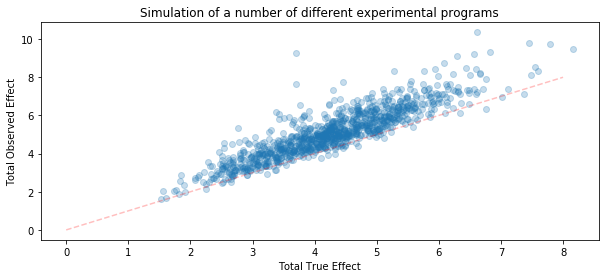

In [134]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
df.plot(style='o', alpha=0.25, ax=ax)

plt.ylabel('Total Observed Effect')
plt.xlabel('Total True Effect')
plt.title('Simulation of a number of different experimental programs')
ax.legend().set_visible(False)

# plot an y = x line
x = np.linspace(0, int(np.max(total_true_effects)), 100)
plt.plot(x,x, '--r', alpha=0.25);

The plot above shows, for simulated data, how summing up the total observed effect systematically overestimates the total true effect. This is why nearly all data points lie above the line `y = x`, plotted in light red.

### Relationship to Statistical Power

Winner's curse describes a selection bias in which experimental results systematically overestimate the impact of a change. Due to random fluctuations, your observed effect will vary. And only the largest observed effect will pass through the significance filter; any abnormally low observed effects will be removed by this filter.

This problem is amplified for small sample sizes (i.e. low power), where your estimate of the true effect will be more random. We can see this by varying the parameter `n` (the sample size), in the simulation function.

In [168]:
n_simulations = 1000

data = []

for n in [10, 50, 500]:
    total_true_effects = []
    total_observed_effects = []
    for _ in range(n_simulations):
        total_true_effect, total_observed_effect = simulate_experiments(n_experiments=30, n=n)
        total_true_effects.append(total_true_effect)
        total_observed_effects.append(total_observed_effect)
    
    df = pd.DataFrame(index = total_true_effects, 
                  data = total_observed_effects,
                  columns = ['Bottoms-up Effect'])
    df.index.name = 'True Effect'    
    df['Sample Size'] = n
    
    data.append(df)
    

In [169]:
df = pd.concat(data)

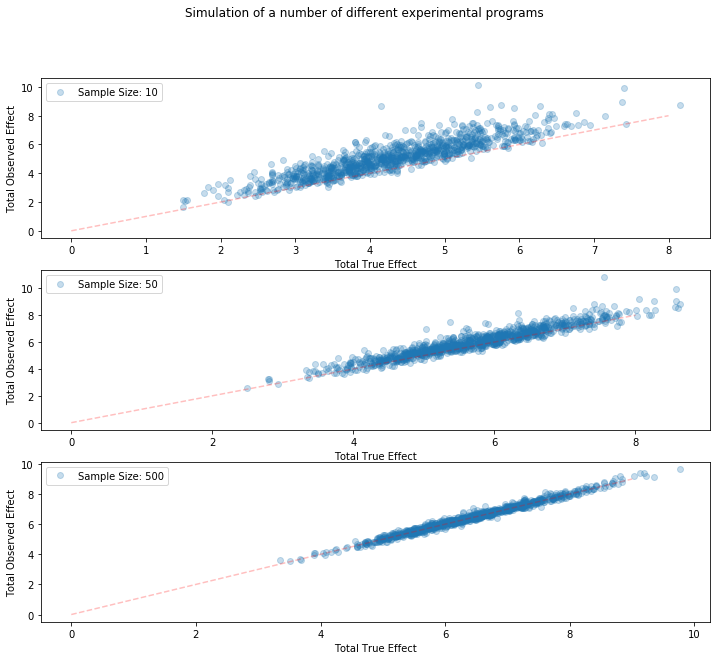

In [175]:
fig, axes = plt.subplots(3, 1, figsize=(12,10))
for ax, sample_size in zip(axes, df['Sample Size'].unique()):
    subset = df[df['Sample Size'] == sample_size]
    subset['Bottoms-up Effect'].plot(style='o', alpha=0.25, ax=ax)
    
    # plot an y = x line
    x = np.linspace(0, int(subset.index.max()), 100)
    ax.plot(x,x, '--r', alpha=0.25);
    
    ax.set_ylabel('Total Observed Effect')
    ax.set_xlabel('Total True Effect')
    ax.legend(['Sample Size: {}'.format(sample_size)])

plt.suptitle('Simulation of a number of different experimental programs');

https://stats.stackexchange.com/questions/176384/do-underpowered-studies-have-increased-likelihood-of-false-positives
    
    An additional issue often named regarding underpowered studies is that they lead to overestimated effect sizes. The reasons is that a) with lower power, your estimates of the true effects will become more variable (stochastic) around their true value, and b) only the strongest of those effects will pass the significance filter when the power is low. One should add though that this is a reporting problem that could easily be fixed by discussing and reporting all and not only significant effects.